# Verilog Overlay Tutorial

This is a tutorial targeted at Verilog and Python users who wish to use Zynq 7000 to do Verilog FPGA development and interface their Verilog in the PL to the PS system.

In this case, similar to the prior page, we will use Verilog to develop a Simple Logic Module. My code and notes are available at <a href=http://github.com/rogerpease/PYNQPublicRepository/SimpleLogicModule>http://github.com/rogerpease/PYNQPublicRepository/SimpleLogicModule</A>

I developed this demo on Vivado 2019.2 using a TUL-2 board. I am still learning this specific tool myself so there may be improvements- comments and updates are always welcome!

## Design Steps and decisions

The general flow of design steps I followed are:

 1) Develop your IP. You will interface to your IP through a memory mapped interface.    
 2) Instance your IP in an AXI IP Wrapper. The AXI IP makes your design memory mappable by the CPU. 
 3) Instance the AXI-wrapped IP in an FPGA level project which you will then build bitstream and tcl files from. 


## Developing your base IP

To interface as a memory mapped peripheral, you will simply assume each input and output port you need to control through the CPU (except clock and reset) map to a specific address.

For this first example we are going to use a simple project similar to the adder used in the previous example.

```Verilog 
module SimpleLogicModule (
    input [31:0] a,
    input [31:0] b,
    output [31:0] sum,
    output [31:0] difference,
    output [31:0] bitwiseAnd,
    output [31:0] bitwiseOr,
    output [31:0] bitwiseXor,
    output [31:0] bitwiseXNor
    );
    assign sum = a+b;
    assign difference = a-b;
    assign bitwiseAnd = a & b;
    assign bitwiseOr  = a | b;
    assign bitwiseXor  = a ^  b;
    assign bitwiseXNor = a ~^ b;
endmodule
```

For simplicity purposes I will assume you've created the proper testbenches and thoroughly tested your IP.


## Instancing your IP inside an AXI Peripheral

### Planning
We will make a simple memory mapping:
* Input Ports a and b map to address offset 0x00 and 0x04
* Output Ports sum, difference, And, Or, Xor and Xnor map to 0x08-0x1c. 


### Base AXI IP

Create a new project called "SimpleLogicModuleAXIIP". Once open, go to "Tools"->"Create and Package New IP". Create a new AXI4 Peripheral. It should be an AXI Lite Slave Mode, 8 32-bit registers. On the next page Select "Edit IP".

### Instancing your IP

You should see generated RTL like this:

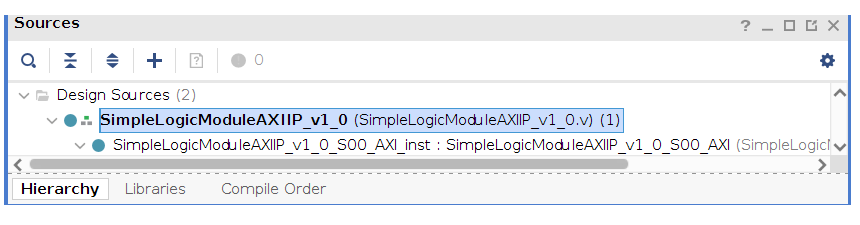
   

#### Updating the AXI IP: 

In the SimpleLogicModule...inst file, at the bottom, add your logic in between the User Logic lines.

    // Add user logic here_
    wire [31:0] sum;
    wire [31:0] difference;
    wire [31:0] bitwiseAnd;
    wire [31:0] bitwiseOr;
    wire [31:0] bitwiseXor;
    wire [31:0] bitwiseXNor;
    
    SimpleLogicModule SimpleLogicModule_inst(
     .a(slv_reg0),
     .b(slv_reg1),
     .sum(sum),
     .difference(difference),
     .bitwiseAnd(bitwiseAnd),
     .bitwiseOr(bitwiseOr),
     .bitwiseXor(bitwiseXor),
     .bitwiseXNor(bitwiseXNor)
    );
	// _User logic ends_

slv_rev0 is address offset 0x0, slv_reg1 is 0x04, etc. If you had signals tied to other blocks (FPGA pins,etc) you would of course add them to the indicated area in the module definition. 

Now, update the register write logic... It will be an always block with a case statement gated by slv_reg_wren. In this case we want to update those registers ourselves (as opposed to having the CPU write them) so we remove the cases for slv_rev2-7 and replace them with: 

        slv_reg2 <=  sum;         //(Address 0x08)
        slv_reg3 <=  difference;  //(Address 0x0C)
        slv_reg4 <=  bitwiseAnd;  //(Address 0x10)
        slv_reg5 <=  bitwiseOr;   //(Address 0x14)
        slv_reg6 <=  bitwiseXor;  //(Address 0x18)
        slv_reg7 <=  bitwiseXNor; //(Address 0x1C)

Do this outside the if (slv_reg_wren) statement so they update on every cycle. 

Once you have completed these steps, do a basic simulation compile to make sure you have no syntax errors and go back to the "Package IP " tab. *Make sure the source code for your IP is included in the File Groups.*

### Instantiating your AXI IP in an FPGA

So far we have made our base IP and then placed it into an AXI IP Instance so it can be connected to the AXI IP chain. 

Now we will start a new project named "SimpleLogicModuleFPGAProject". It's an RTL project. Don't include any IP.  

Create a new Block Design called "SimpleLogicModuleFPGADesign". Add your ip_repo where you built the AXI IP to the IP Catalog (from the "Project Manager"->"Settings" Menu).

Now instance two items using the + button:
* Your "SimpleLogicModuleAXIIP" (if you can't find it you probably forgot to add it to the library).  
* The Zynq 7000 Instance
   
You will see a window like this: 

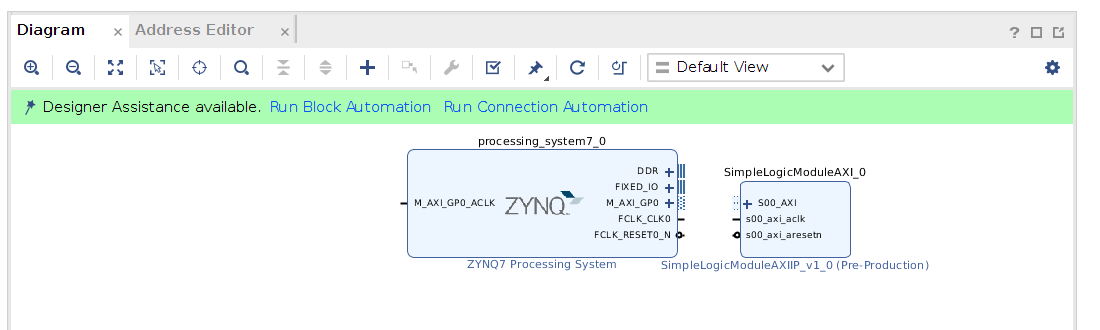

Click on both Run Block Automation and Run Connection Automation. 

Then, select the top level Design file and click Flow->Create Design Wrapper (the compiler needs to compile RTL, not board files). 


Select "Generate Bitstream" to generate a bitstream. 



## Running the IP on your TUL board

### Collect Bit and HWH Files

Once you have built your FPGA Image, collect the following:

* The .hwh file (it will be named after your project, like SimpleLogicModule.hwh). Rename it to SimpleLogicModule.hwh
* The .bit file (it will be named after your wrapper, like SimpleLogicModule_wrapper.bit). Rename it to SimpleLogicModule.bit
* SimpleLogicModule.py (included in python/)

And copy them to your Zynq board. Move the .hwh and .bit into pynq/overlays/SimpleLogicModule (you may need to make this directory).

### Test in Python

Python interface is very simple: 

    from pynq import Overlay
    overlay = Overlay('SimpleLogicModule.bit');
    # Make sure this is in    pynq/overlays/SimpleLogicModule/SimpleLogicModule.bit
    # and the hwh file is in  pynq/overlays/SimpleLogicModule/SimpleLogicModule.hwh
    aAddress         = 0x00
    bAddress         = 0x04
    sumAddress       = 0x08

    overlay.SimpleLogicModuleAXI_0.write(aAddress,a)
    overlay.SimpleLogicModuleAXI_0.write(bAddress,b)
    actualSum        = overlay.SimpleLogicModuleAXI_0.read(sumAddress)

     
  A full test script is available in python subdirectory of the repository above. 


## GOTCHAS


Be sure IP of all source files (including your module) is 
exported when you do AXI peripheral packaging.  
See: https://forums.xilinx.com/t5/Design-Entry/Can-t-get-custom-IP-with-FIFO-to-synthesize-in-the-top-level/m-p/564966 Otherwise the FPGA Implementation step will not be able to find the proper IP and adding it afterwards doesn''t seem to work.

Be sure to make a design wrapper HDL out of the top level. Use "Create Design Wrapper" by right-clicking 
  on the top level of the FPGAImplementation. The bitstream program can''t make a file out of board descriptions- it needs the HDLs.

Don't put slv__reg2 <= sum and slv_reg3 <= product into the case statement for the AXI write. I did this and realized I needed
     to initiate a ghost write cycle to those addresses to make the write happen.


## References
[1] https://www.xilinx.com/video/hardware/creating-an-axi-peripheral-in-vivado.html  This video walks you through the basics of creating an AXI peripheral.
[2] https://www.xilinx.com/support/documentation/ip_documentation/axi_ref_guide/latest/ug1037-vivado-axi-reference-guide.pdf